##Load Libraries

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!pip install scikit-learn==1.5.0

In [87]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

import xgboost

from google.colab import drive
import os

import warnings
warnings.filterwarnings('ignore')

#Column transformers
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

#imbalance learn library
from imblearn.pipeline import Pipeline as ImbPipeline

#hyperparameters for machine learning models
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#Validate models
from sklearn.model_selection import cross_validate,RepeatedKFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, mean_absolute_percentage_error, r2_score



#models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

#oversampling & undersampling
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


## Load data

In [88]:
drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/Colab Notebooks/3_Trimestre/MLOps/Semana_4/Tarea')
os.chdir('/content/drive/MyDrive/Colab Notebooks/MNA/4rto_Trimestre/MLOps/Semana_4/Tarea')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
#pd.set_option('display.max_rows', None)

In [90]:
dataset_modified=pd.read_csv('df_final_validated.csv',low_memory=False )

In [91]:
dataset_modified=dataset_modified.convert_dtypes()

In [92]:
dataset_modified

Output hidden; open in https://colab.research.google.com to view.

In [93]:
print(dataset_modified.dtypes)

url                              string[python]
timedelta                                 Int64
n_tokens_title                          Float64
n_tokens_content                        Float64
n_unique_tokens                         Float64
n_non_stop_words                        Float64
n_non_stop_unique_tokens                Float64
num_hrefs                               Float64
num_self_hrefs                          Float64
num_imgs                                Float64
num_videos                              Float64
average_token_length                    Float64
num_keywords                            Float64
data_channel_is_lifestyle                 Int64
data_channel_is_entertainment             Int64
data_channel_is_bus                       Int64
data_channel_is_socmed                    Int64
data_channel_is_tech                      Int64
data_channel_is_world                     Int64
kw_min_min                              Float64
kw_max_min                              

## Step 1 EDA - Clean Dataframe and describe columns

###Classes and functions to clean columns and insert into pipeline

In [94]:
class CleanNumericColumns(BaseEstimator, TransformerMixin):
    """
    1. Lower-cases + trims selected columns
    2. Casts to numeric (non-parsable values → NaN)
    3. Imputes NaN with the training-set median
    """
    def __init__(self, columns=None):
        """
        columns : list of column names to clean; if None, all columns
        """
        self.columns = columns              # hyper-parameter (used by __init__)

    # ----------- Fit -----------
    def fit(self, X, y=None):
        X_ = X.copy()
        cols = self.columns or X_.columns   # default: every column

        self.medians_ = {}                  # learned parameter(s) end with "_"
        for c in cols:
            col_clean = (
                X_[c].astype(str)
                    .str.lower()
                    .str.strip()
                    .pipe(pd.to_numeric, errors='coerce')
            )
            self.medians_[c] = col_clean.median()
        self.cols_ = cols                   # save for use in transform
        return self                         # always return self

    # ----------- Transform -----------
    def transform(self, X):
        X = X.copy()
        for c in self.cols_:
            X[c] = (
                X[c].astype(str)
                    .str.lower()
                    .str.strip()
                    .pipe(pd.to_numeric, errors='coerce')
                    .fillna(self.medians_[c])
            )
        return X

    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols_)

In [95]:
class CleanBooleanColumns(BaseEstimator, TransformerMixin):
    """
    1. Lower-cases + trims selected columns
    2. Casts to numeric; NaN if coercion fails
    3. Imputes NaN with the mode (most frequent) value from the *training* data
    4. Converts to strict 0/1 flag based on equality with 1
    """
    def __init__(self, columns=None):
        self.columns = columns          # list of columns (or None = all)

    # ---------------- fit ----------------
    def fit(self, X, y=None):
        X_ = X.copy()
        cols = self.columns or X_.columns
        self.modes_ = {}

        for c in cols:
            col_clean = (
                X_[c].astype(str)
                    .str.lower()
                    .str.strip()
                    .pipe(pd.to_numeric, errors='coerce')
            )
            # .mode() returns Series; take the first element
            self.modes_[c] = col_clean.mode(dropna=True)[0]

        self.cols_ = cols
        return self

    # ------------- transform -------------
    def transform(self, X):
        X = X.copy()
        for c in self.cols_:
            X[c] = (
                X[c].astype(str)
                    .str.lower()
                    .str.strip()
                    .pipe(pd.to_numeric, errors='coerce')
                    .fillna(self.modes_[c])
                    .isin([1])          # True if value == 1
                    .astype(int)        # → 0/1 integer
            )
        return X

    # (Optional) expose feature names so ColumnTransformer → OneHotEncoder pipelines work
    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols_)

In [96]:
def _clean_string_columns(X, columns):
    """
    • Cast to string
    • Lower-case + strip
    • Keep value only if it starts with 'http', else set to <NA>

    Parameters
    ----------
    X : pandas DataFrame
    columns : list[str] – columns to clean (must exist in X)

    Returns
    -------
    X_new : pandas DataFrame (copy of X with cleaned columns)
    """
    X = X.copy()
    for c in columns:
        X[c] = (
            X[c].astype(str)
                 .str.lower()
                 .str.strip()
                 .where(lambda s: s.str.startswith('http'), pd.NA)
        )
    return X

In [97]:
class CleanStringColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        # stateless – nothing to learn
        self.cols_ = self.columns or X.columns.tolist()
        return self

    def transform(self, X):
        return _clean_string_columns(X, self.cols_)

    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols_)

In [98]:
def _drop_rows_where_url_is_nan(X):
    """Return a copy of X with rows removed if url is missing (<NA>)."""
    return X.loc[X['url'].notna()].reset_index(drop=True)

drop_bad_url = FunctionTransformer(
    _drop_rows_where_url_is_nan,
    feature_names_out='one-to-one'   # keeps column names unchanged
)

def _drop_duplicate_url(X):
    return X.drop_duplicates(subset='url', keep='first').reset_index(drop=True)

drop_dup_url = FunctionTransformer(_drop_duplicate_url,
                                   feature_names_out='one-to-one')

In [99]:
def delete_outliers(
        df,
        k=1.5,          # IQR multiplier
        max_cols=1,     # row dropped if > max_cols columns flag it
        return_counts=False
    ):
    num_cols = df.select_dtypes(include=[np.number]).columns
    col_counts = {}

    mask_df = pd.DataFrame(index=df.index, columns=num_cols, dtype=bool)

    for col in num_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k*iqr, q3 + k*iqr
        col_mask = (df[col] < lower) | (df[col] > upper)

        mask_df[col] = col_mask
        col_counts[col] = int(col_mask.sum())

    row_counts = mask_df.sum(axis=1)
    row_mask   = row_counts > max_cols

    cleaned_df = df.loc[~row_mask].reset_index(drop=True)

    if return_counts:
        return cleaned_df, pd.Series(col_counts).sort_values(ascending=False)
    return cleaned_df

def _drop_outliers(X):
    # delete_outliers returns only the cleaned df when return_counts=False
    return delete_outliers(X, k=1.5, max_cols=10, return_counts=False)

drop_outliers = FunctionTransformer(_drop_outliers,
                                    feature_names_out='one-to-one')


In [100]:
def clip_numeric_ranges(X):
    X = X.copy()
    for c in columns_0_to_1:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors='coerce').clip(0, 1)
    for c in columns_neg1_to_1:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors='coerce').clip(-1, 1)
    for c in columns_neg1_to_0:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors='coerce').clip(-1, 0)
    return X

clip_ranges = FunctionTransformer(clip_numeric_ranges,
                                  feature_names_out='one-to-one')

### Define column type

In [101]:
string_columns=['url']
bool_columns=['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday','is_weekend']
num_columns=['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03','LDA_04', 'abs_title_sentiment_polarity', 'abs_title_subjectivity', 'average_token_length', 'avg_negative_polarity', 'avg_positive_polarity', 'global_rate_negative_words', 'global_rate_positive_words', 'global_sentiment_polarity', 'global_subjectivity', 'kw_avg_avg', 'kw_avg_max', 'kw_avg_min', 'kw_max_avg', 'kw_max_max', 'kw_max_min', 'kw_min_avg', 'kw_min_max', 'kw_min_min', 'max_negative_polarity', 'max_positive_polarity', 'min_negative_polarity', 'min_positive_polarity', 'mixed_type_col', 'n_non_stop_unique_tokens', 'n_non_stop_words', 'n_tokens_content', 'n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_imgs', 'num_keywords', 'num_self_hrefs', 'num_videos', 'rate_negative_words', 'rate_positive_words', 'timedelta', 'title_sentiment_polarity', 'title_subjectivity','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','shares']

In [102]:
len(string_columns),len(bool_columns),len(num_columns)

(1, 14, 47)

### Classify numeric columns

In [103]:
# Clip values to match original dataset range
columns_0_to_1 = ["n_unique_tokens","n_non_stop_words","n_non_stop_unique_tokens",
           "LDA_00","LDA_01","LDA_02","LDA_03","LDA_04","global_rate_positive_words",
           "global_subjectivity","global_rate_negative_words",
           "rate_positive_words","rate_negative_words","avg_positive_polarity","min_positive_polarity","max_positive_polarity"
           "title_subjectivity","abs_title_subjectivity","abs_title_sentiment_polarity"]

columns_neg1_to_1 = ["global_sentiment_polarity","title_sentiment_polarity"]

columns_neg1_to_0 = ["max_negative_polarity", "avg_negative_polarity","min_negative_polarity"]

In [104]:
len(columns_0_to_1),len(columns_neg1_to_1),len(columns_neg1_to_0)

(18, 2, 3)

### Preprocess columns

In [105]:
preprocess = ColumnTransformer(
    transformers=[
        ('num' , CleanNumericColumns(num_columns) ,  num_columns),
        ('bool', CleanBooleanColumns(bool_columns),  bool_columns),
        ('str' , CleanStringColumns(string_columns), string_columns),
    ],
    remainder='drop',                # keep only the columns above
    verbose_feature_names_out=False
).set_output(transform='pandas')     # ← keep pandas DataFrame & names


In [106]:
cleaning_pipe = Pipeline([
    ('prep', preprocess),
 #   ('drop_bad_url', drop_bad_url),
 #   ('drop_dup_url',  drop_dup_url),
 #   ('drop_outliers',  drop_outliers),
 #   ('clip_ranges',    clip_ranges)
])


In [107]:
# Fit *once* on your full DataFrame (no y needed)
cleaned_df = cleaning_pipe.fit_transform(dataset_modified)

In [108]:
print("Original shape :", dataset_modified.shape)
print("Cleaned shape  :", cleaned_df.shape)
print("Any NA in url? :", cleaned_df['url'].isna().any())
print("Duplicate urls :", cleaned_df['url'].duplicated().any())

Original shape : (39235, 62)
Cleaned shape  : (39235, 62)
Any NA in url? : False
Duplicate urls : False


### Describe the columns

In [109]:
cleaned_df.dtypes

,0
LDA_00,float64
LDA_01,float64
LDA_02,float64
LDA_03,float64
LDA_04,float64
abs_title_sentiment_polarity,float64
abs_title_subjectivity,float64
average_token_length,float64
avg_negative_polarity,float64
avg_positive_polarity,float64


In [110]:
cleaned_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
LDA_00,39235.0,NaN,NaN,NaN,0.1844,0.261623,0.010289,0.025182,0.033402,0.240389,0.926994
LDA_01,39235.0,NaN,NaN,NaN,0.142881,0.220038,0.01029,0.025032,0.033348,0.156095,0.925947
LDA_02,39235.0,NaN,NaN,NaN,0.215967,0.28094,0.010005,0.028572,0.040007,0.327956,0.919999
LDA_03,39235.0,NaN,NaN,NaN,0.222839,0.293553,0.010838,0.028572,0.040001,0.366368,0.926534
LDA_04,39235.0,NaN,NaN,NaN,0.233914,0.28832,0.010679,0.02858,0.047619,0.396494,0.927191
abs_title_sentiment_polarity,39235.0,NaN,NaN,NaN,0.19819,4.812824,0.0,0.0,0.0,0.25,658.0
abs_title_subjectivity,39235.0,NaN,NaN,NaN,0.345579,0.188198,0.0,0.166667,0.5,0.5,0.975
average_token_length,39235.0,NaN,NaN,NaN,4.633962,0.581449,2.02248,4.483267,4.667038,4.858921,7.069518
avg_negative_polarity,39235.0,NaN,NaN,NaN,-0.259209,0.126253,-1.0,-0.325926,-0.253332,-0.1875,0.0
avg_positive_polarity,39235.0,NaN,NaN,NaN,0.353889,0.103435,0.0,0.307661,0.358766,0.409552,1.0


## Step 2 EDA - graphs

### Function to graph

In [111]:
def graph_features(df,num_columns,bool_columns):
  # ───────────────────────────────────────────────────────────
  # 1.  Decide how many plots we need
  # ───────────────────────────────────────────────────────────
  n_plots = len(num_columns) * 2 + len(bool_columns)   # 2 plots per numeric feature

  # choose grid size automatically (≤4 columns usually looks good)
  n_cols  = 4
  n_rows  = math.ceil(n_plots / n_cols)

  # ───────────────────────────────────────────────────────────
  # 2.  Create the figure canvas
  # ───────────────────────────────────────────────────────────
  fig, axes = plt.subplots(n_rows, n_cols,
                          figsize=(n_cols * 4, n_rows * 3),
                          constrained_layout=True)      # auto-spacing
  axes = axes.ravel()        # 1-D iterator over all axes

  # ───────────────────────────────────────────────────────────
  # 3.  Draw the plots
  # ───────────────────────────────────────────────────────────
  idx = 0
  BINS=60
  # Numeric: histogram + boxplot
  for col in num_columns:
      # Histogram (+ optional KDE line)
      sns.histplot(df[col],
                  bins=BINS,
                  ax=axes[idx],
                  kde=True, color='steelblue')
      axes[idx].set_title(f'{col}\nHistogram', fontsize=9)
      idx += 1

      # Boxplot (vertical wastes less horizontal space)
      sns.boxplot(y=df[col],
                  ax=axes[idx],
                  color='salmon')
      axes[idx].set_title(f'{col}\nBoxplot', fontsize=9)
      idx += 1

  # Boolean / nominal: countplot
  for col in bool_columns:
      sns.countplot(x=df[col],
                    ax=axes[idx],
                    palette='pastel')
      axes[idx].set_title(f'{col}\nCount', fontsize=9)
      idx += 1

  # ───────────────────────────────────────────────────────────
  # 4.  Remove any unused axes to keep the grid tidy
  # ───────────────────────────────────────────────────────────
  for j in range(idx, len(axes)):
      fig.delaxes(axes[j])

  # Global style tweaks
  sns.despine(fig=fig)           # remove top/right spines
  plt.show()

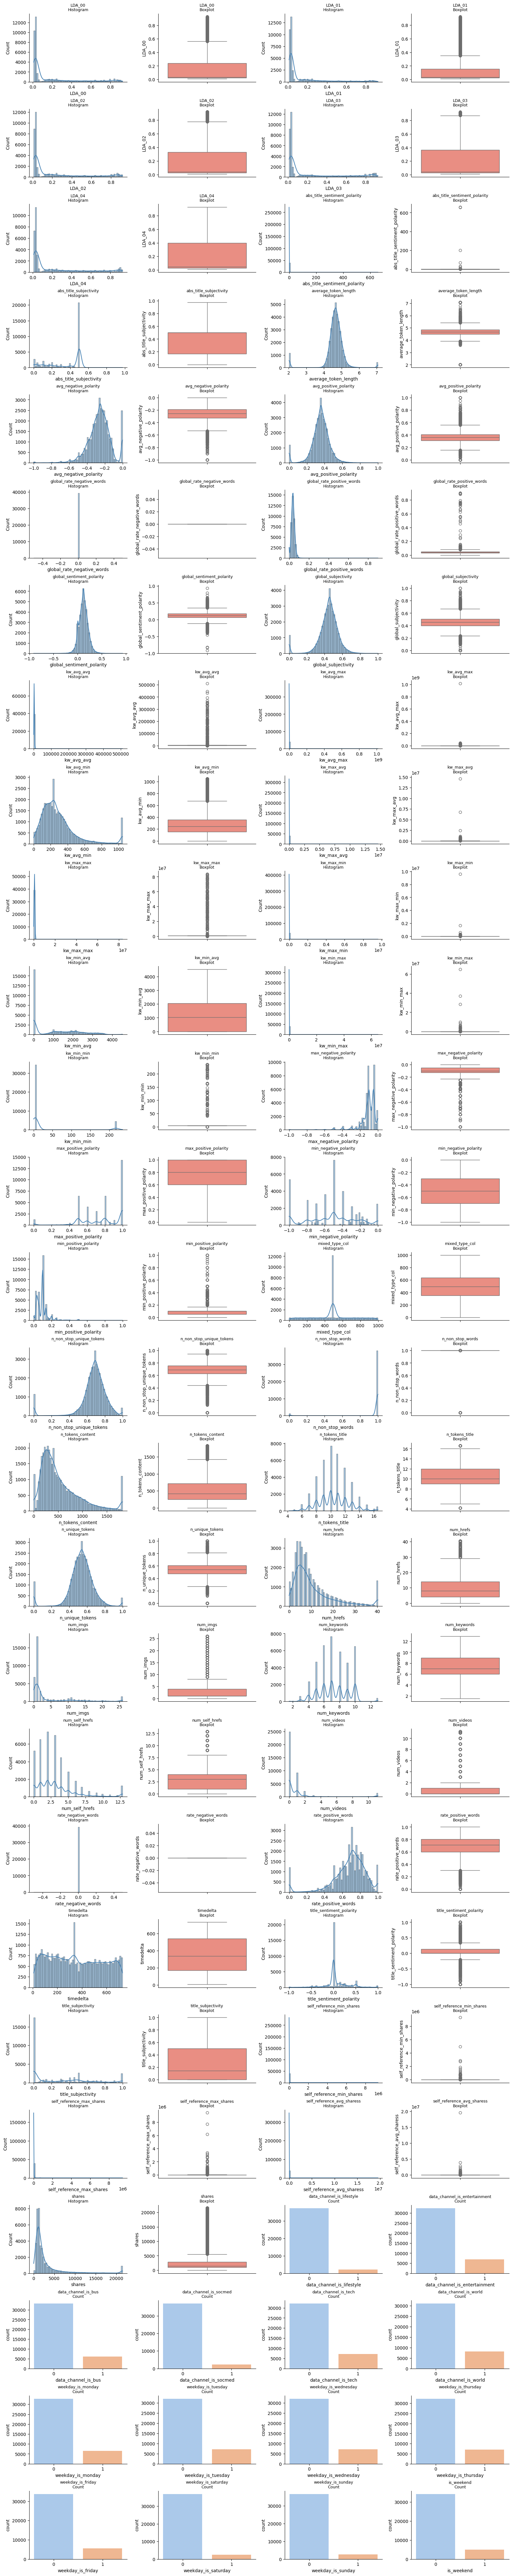

In [112]:
graph_features(df=cleaned_df,num_columns=num_columns,bool_columns=bool_columns)

## ML model

### Split dataframe for Train, Validation and Test and drop columns that are redundant

### Agregar analisis de correlacion

In [ ]:
corr_matrix = cleaned_df.corr(numeric_only=True)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

##### The following columns where removed from the X



1.   average_token_length since it is an average correlated to n_tokens_content
2.   kw_avg_min since it is an average correlated to kw_min_min and kw_max_min
3.   kw_avg_max since it is an average correlated to kw_max_min and kw_max_max
4.   self_reference_min_shares since it is normally data obtained after models have been deployed
5.   self_reference_max_shares since it is normally data obtained after models have been deployed
6.   self_reference_avg_sharess since it is normally data obtained after models have been deployed
7.   is_weekend since we have columns for saturday and sunday
8.   weekday_is_sunday since we can determine by knowing if the other days did not apply
9.  avg_positive_polarity since it is an abg correlated to min_positive_polarity and max_positive_polarity
10.  avg_negative_polarity since it is an abg correlated to min_negative_polarity and max_negative_polarity
11. url since it is a string column that can be used as the index
12. shares since that is our output
13. kw_avg_avg since it is correlated to kw_max_avg and kw_min_avg
14. timedelta since it is a not predictive column







In [114]:
#Dataframe for X
index = dataset_modified["url"]
y = cleaned_df["shares"]
X=cleaned_df.drop(columns={'timedelta','average_token_length','kw_avg_min','kw_avg_max','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','is_weekend','weekday_is_sunday','avg_positive_polarity','avg_negative_polarity','url','shares','kw_avg_avg'})

In [115]:
X_train, X_valtest, y_train, y_valtest = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=None
)

X_val, X_test, y_val, y_test = train_test_split(
    X_valtest, y_valtest,
    test_size=0.50,
    random_state=42,
    stratify=None
)

print('Original dataframe',dataset_modified.shape)
print('Cleaned dataframe',cleaned_df.shape)
print('X_train', X_train.shape)
print('X_val', X_val.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_val', y_val.shape)
print('y_test', y_test.shape)

Original dataframe (39235, 62)
Cleaned dataframe (39235, 62)
X_train (27464, 48)
X_val (5885, 48)
X_test (5886, 48)
y_train (27464,)
y_val (5885,)
y_test (5886,)


### Pipeline to improve features distributions





In [118]:
#Se elimino shares de num_cols

string_columns=['url']
bool_columns=['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday']
num_columns=['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03','LDA_04', 'abs_title_sentiment_polarity', 'abs_title_subjectivity', 'global_rate_negative_words', 'global_rate_positive_words', 'global_sentiment_polarity', 'global_subjectivity', 'kw_max_avg', 'kw_max_max', 'kw_max_min', 'kw_min_avg', 'kw_min_max', 'kw_min_min', 'max_negative_polarity', 'max_positive_polarity', 'min_negative_polarity', 'min_positive_polarity', 'mixed_type_col', 'n_non_stop_unique_tokens', 'n_non_stop_words', 'n_tokens_content', 'n_tokens_title', 'n_unique_tokens', 'num_hrefs', 'num_imgs', 'num_keywords', 'num_self_hrefs', 'num_videos', 'rate_negative_words', 'rate_positive_words', 'title_sentiment_polarity', 'title_subjectivity']
print(+len(num_columns)+len(bool_columns))

48


In [119]:
# Variables numéricas:
numeric_pipe = Pipeline(steps=[('impute_median',SimpleImputer(strategy='median')),('yeo-johnson_transformer',PowerTransformer(method='yeo-johnson',standardize=False)),('standard_scaler',StandardScaler())])


In [120]:
# Variables categóricas binaries:
bool_pipe = Pipeline(steps=[('impute_mode',SimpleImputer(strategy='most_frequent'))])
bool_pipe2 = Pipeline(steps=[('impute_mode',SimpleImputer(strategy='most_frequent'))])

In [121]:
# Conjuntas las transformaciones de todo tipo de variable y
# deja sin procesar aquellas que hayas decidido no transformar:

columnasTransformer = ColumnTransformer(transformers=[('num_pipe',numeric_pipe,num_columns),('bin_pipe',bool_pipe,bool_columns),],remainder='passthrough')

columnasTransformer2 = ColumnTransformer(transformers=[('num_pipe',numeric_pipe,num_columns),('bin_pipe',bool_pipe2,bool_columns),],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')

Xtmp = X_train.copy()
tmp = columnasTransformer.fit_transform(Xtmp)
tmp2=columnasTransformer2.fit_transform(Xtmp)
print("Dimensión de los datos de entrada:")
print("antes de aplicar las transformaciones:", Xtmp.shape)
print("después de aplicar las transformaciones:", tmp.shape)

Dimensión de los datos de entrada:
antes de aplicar las transformaciones: (27464, 48)
después de aplicar las transformaciones: (27464, 48)


### Histogram after pipeline

In [122]:
tmp2.head()

,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,abs_title_sentiment_polarity,abs_title_subjectivity,global_rate_negative_words,global_rate_positive_words,global_sentiment_polarity,...,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday
38677,1.549072,-0.424829,0.846910,0.444943,-0.734875,1.383421,-0.772061,0.0,0.042486,1.293728,...,1,0,0,0,0,0,0,1,0,0
5096,0.835936,-0.551436,-0.746486,1.556585,-0.809549,1.383421,-1.315197,0.0,-1.852629,-4.404387,...,0,0,0,0,0,0,1,0,0,0
26446,-0.556042,-0.426287,1.657392,-0.650452,-0.738698,-0.883153,0.864344,0.0,-0.004052,0.752190,...,0,0,0,1,0,1,0,0,0,0
5588,-0.419554,-0.241316,1.493192,-0.539757,0.723072,-0.466910,0.316645,0.0,0.042486,-0.169173,...,0,0,0,1,0,0,0,0,1,0
16614,0.704288,-0.849119,-0.915578,1.593365,-0.958407,-0.883153,0.864344,0.0,0.389315,1.048159,...,0,0,0,0,0,0,0,0,1,0


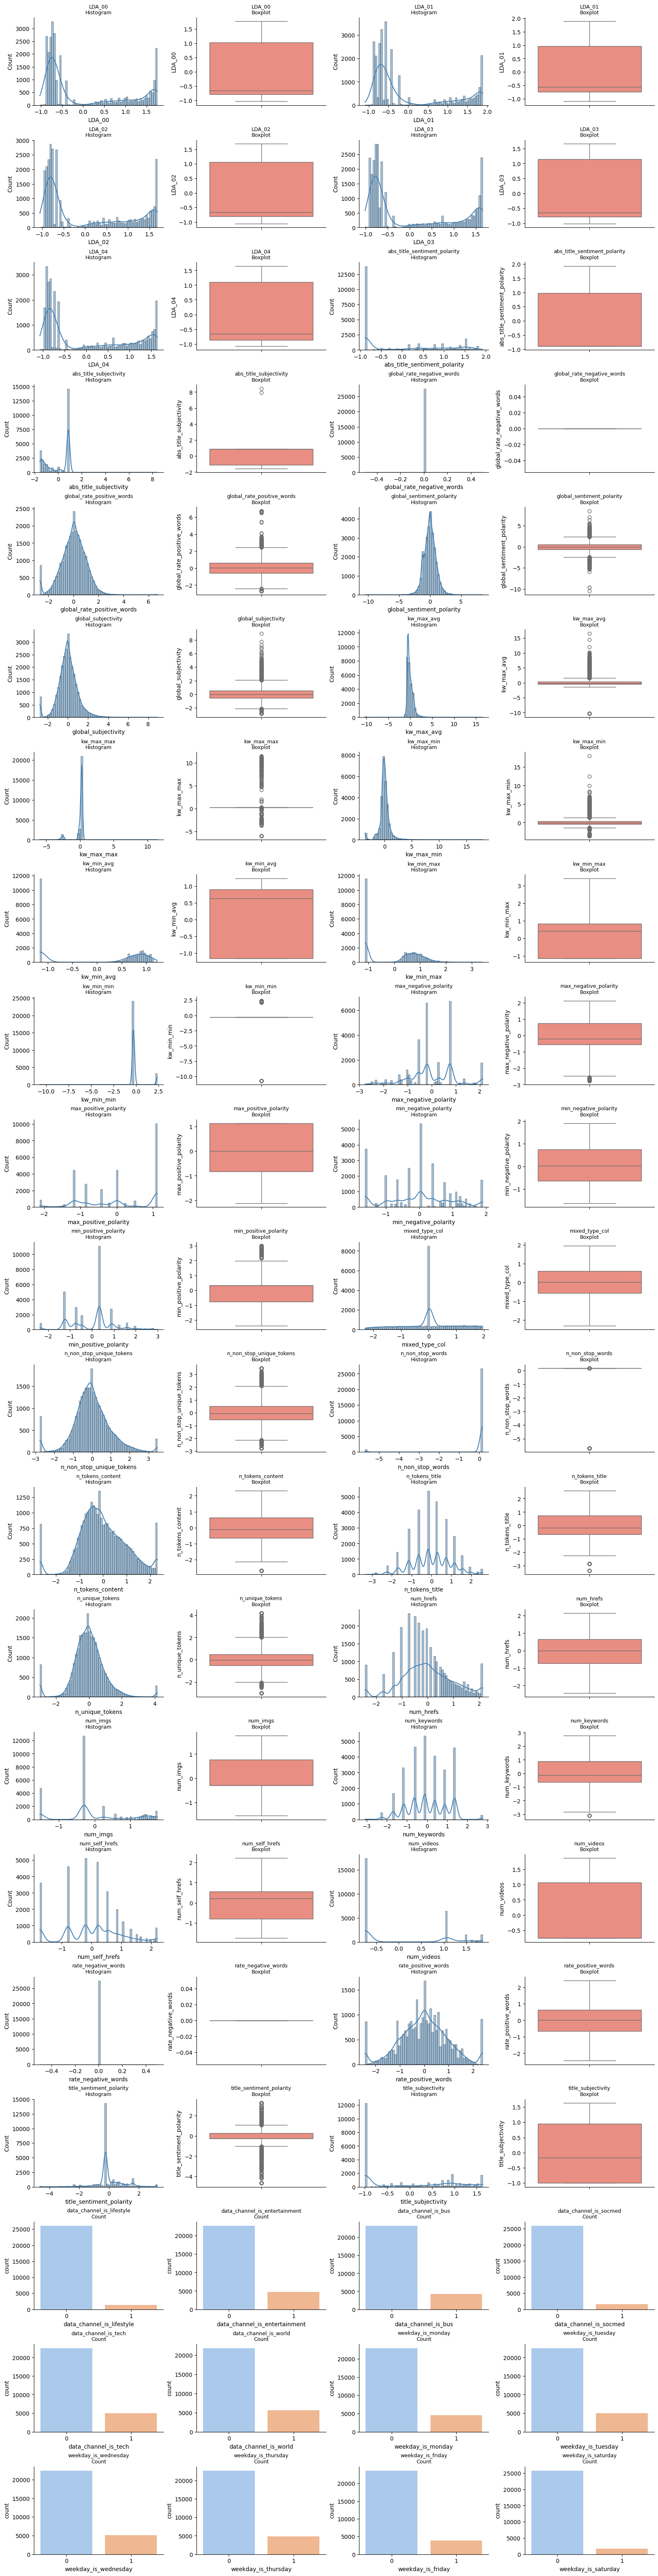

In [123]:
graph_features(df=tmp2,num_columns=num_columns,bool_columns=bool_columns)

### Merge X_train and X_test

In [125]:
# Como se va a utilizar Validación-Cruzada, concatena los conjuntos de entrenamiento
# y prueba en uno nuevo conjunto aumentado que llamaremos trainval:


# ************* Inlcuye aquí tu código:**************************


Xtraintest = pd.concat([X_train,X_test])
ytraintest = pd.concat([y_train,y_test])


# *********** Aquí termina la sección de agregar código *************


# Veamos cuántas variables nuevas se introducen con las transformaciones One-Hot-Encoding:
Xtmp = Xtraintest.copy()
tmp = columnasTransformer.fit_transform(Xtmp)
print("Dimensión de las variables de entrada ANTES de las transformaciones:", Xtmp.shape)
print("Dimensión de las variables de entrada DESPUÉS de las transformaciones:", tmp.shape)

Dimensión de las variables de entrada ANTES de las transformaciones: (33350, 48)
Dimensión de las variables de entrada DESPUÉS de las transformaciones: (33350, 48)


#### functions

In [126]:
# Helper: RMSE scorer (scikit-learn does not provide it directly)
rmse_scorer = make_scorer(
    mean_squared_error,
    greater_is_better=False,   # tell sklearn that “bigger is worse”
    squared=False              # √MSE  instead of MSE
)

In [127]:
def mi_fun_nosampling(modelo, nombre, X, y):
    """
    Evaluate a *regression* model (wrapped in a Pipeline with the global
    columnasTransformer) using repeated k-fold CV and several regression
    metrics, then print the aggregated results.

    Parameters
    ----------
    modelo : estimator
        Any scikit-learn compatible regressor (e.g., RandomForestRegressor).
    nombre : str
        A tag that appears in the printed summary.
    X : pd.DataFrame or np.ndarray
        Features.
    y : array-like
        Target vector.
    """

    print('No sampling method used with column transformation, results:')

    pipeline = Pipeline(steps=[
        ('ct', columnasTransformer),
        ('model', modelo)
    ])

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

    # Metrics to compute
    mis_metricas = {
        'rmse' : rmse_scorer,                        # root-mean-squared error
        'mae'  : 'neg_mean_absolute_error',          # will be negated back
        'mape' : 'neg_mean_absolute_percentage_error',
        'r2'   : 'r2'
    }

    scores = cross_validate(
        pipeline,
        X, np.ravel(y),
        scoring=mis_metricas,
        cv=cv,
        return_train_score=True
    )

    # Pretty printing
    print(f'>> {nombre}')
    for metric_name in mis_metricas.keys():
        values = scores[f'test_{metric_name}']
        # flip the sign for “neg_...” scorers so that smaller is worse
        if metric_name in ['mae', 'mape', 'rmse']:
            values = -values
        mean_val = np.nanmean(values)
        std_val  = np.nanstd(values)
        print(f'\t{metric_name:5s}: {mean_val:.4f} ({std_val:.3f})')

    print('------------------------------------------------------------------------------------------')

In [128]:
# ---------------------------------------------------------
def mi_fun_grid(modelo, nombre, X, y, dicc_grid=None):
    """
    Grid-search helper for REGRESSION models.

    Parameters
    ----------
    modelo : estimator
        Any scikit-learn compatible regressor (e.g., XGBRegressor()).
    nombre : str
        Name that appears in the printed summary.
    X : pd.DataFrame or np.ndarray
        Feature matrix.
    y : array-like
        Target vector.
    dicc_grid : dict or list of dicts
        Hyper-parameter grid to explore (as in GridSearchCV).
    """
    print('Find best parameters while using column transformation')

    # 1. Pipeline ----------------------------------------------------
    pipeline = Pipeline(steps=[
        ('ct', columnasTransformer),  # assumes you defined this globally
        ('model', modelo)
    ])

    # 2. Scoring dictionary -----------------------------------------
    mis_metricas = {
        'rmse':  'neg_root_mean_squared_error',      # lower is better
        'mae':   'neg_mean_absolute_error',
        'mape':  'neg_mean_absolute_percentage_error',
        'r2':    'r2'
    }

    # 3. CV strategy -------------------------------------------------
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

    # 4. Grid search -------------------------------------------------
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=dicc_grid,
        cv=cv,
        scoring=mis_metricas,
        refit='rmse',           # the model returned by .best_estimator_ minimises RMSE
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )

    # 5. Fit ---------------------------------------------------------
    grid_result = grid.fit(X, np.ravel(y))

    # 6. Report ------------------------------------------------------
    best_rmse = -grid_result.best_score_   # flip sign back to positive RMSE
    print(f'>> {nombre}')
    print(f'Mejor RMSE (CV): {best_rmse:.4f} usando {grid_result.best_params_}')
    print('------------------------------------------------------------------------------------------')

    # Optional: display the mean CV value for every metric
    for m in mis_metricas:
        vals = grid_result.cv_results_[f'mean_test_{m}']
        stds = grid_result.cv_results_[f'std_test_{m}']
        # flip sign for neg_ scorers
        if m in ['rmse', 'mae', 'mape']:
            vals = -vals
        print(f'{m:5s}: {vals.min():.4f} – {vals.max():.4f}  (std avg {stds.mean():.3f})')
    print('------------------------------------------------------------------------------------------')

## ML models

### Regresion lineal

In [129]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Puedes consultar la siguiente liga para los métodos de submuestreo o sobremuestreo:
# https://imbalanced-learn.org/stable/references/over_sampling.html

# ************* Inlcuye aquí tu código:**************************

# Selecciona la configuración de valores de hiperparámetros que consideres te da el mejor desempeño:
nombre='Linear_Regression'
modelo =LinearRegression()

#Grid parameters
dicc_grid = {
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__positive': [False, True]  # forces coefficients to be positive
}
#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
#modelo =LinearRegression(C=0.5,penalty='l1',solver='liblinear',random_state=1)


#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)


# *********** Aquí termina la sección de agregar código *************




Find best parameters while using column transformation
Fitting 15 folds for each of 8 candidates, totalling 120 fits
>> Linear_Regression
Mejor RMSE (CV): 3974.5696 usando {'model__copy_X': True, 'model__fit_intercept': True, 'model__positive': False}
------------------------------------------------------------------------------------------
rmse : 3974.5696 – 4081.8782  (std avg 90.238)
mae  : 2340.2179 – 2381.9597  (std avg 32.343)
mape : 1.5913 – 1.6280  (std avg 0.325)
r2   : -0.0035 – 0.0486  (std avg 0.006)
------------------------------------------------------------------------------------------


Find best parameters while using column transformation
Fitting 15 folds for each of 8 candidates, totalling 120 fits
>> Linear_Regression
Mejor RMSE (CV): 3974.5696 usando {'model__copy_X': True, 'model__fit_intercept': True, 'model__positive': False}
------------------------------------------------------------------------------------------
rmse : 3974.5696 – 4081.8782  (std avg 90.238)
mae  : 2340.2179 – 2381.9597  (std avg 32.343)
mape : 1.5913 – 1.6280  (std avg 0.325)
r2   : -0.0035 – 0.0486  (std avg 0.006)
------------------------------------------------------------------------------------------


### k-Vecinos Más Cercanos (kNN)italicized text

In [ ]:
# k-Vecinos más Cercanos : k-Nearest-Neighbors-kNN:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


# ************* Inlcuye aquí tu código:**************************

nombre = 'K_neighbors_nearest'

#Input best parameters into model
modelo = KNeighborsRegressor()

#Grid parameters
dicc_grid = {
    'model__n_neighbors': [5, 11, 15, 21],   # number of neighbors
    'model__weights': ['uniform'],        # weight function
    'model__algorithm': ['auto'],  # search algorithm
    'model__p': [1, 2],                               # 1 = Manhattan, 2 = Euclidean
    #'model__leaf_size': [10, 20, 30, 40, 50]          # affects speed/memory balance
}

#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
#modelo =KNeighborsRegressor(n_neighbors=200)


#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)

Find best parameters while using column transformation
Fitting 15 folds for each of 8 candidates, totalling 120 fits


### Decision tree

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
"""class sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0, monotonic_cst=None)"""

# ************* Inlcuye aquí tu código:**************************

nombre = 'Decision_tree'
modelo = DecisionTreeRegressor()

#Grid parameters
dicc_grid = {
    'model__criterion': ['squared_error', 'absolute_error'],  # loss function
    #'model__splitter': ['best'],        # how to choose splits
    'model__max_depth': [None, 7, 20],  # tree depth limit
    #'model__min_samples_split': [2, 7, 15],   # minimum samples to split an internal node
    #'model__min_samples_leaf': [1, 2, 6, 10],  # minimum samples at a leaf node
    'model__max_features': [None, 'sqrt'],# number of features to consider when looking for best split
    #'model__max_leaf_nodes': [None, 10, 20, 50]  # maximum number of leaf nodes
}
#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
#modelo = DecisionTreeRegressor(criterion='gini',max_depth=3,max_features=25,min_samples_split=3,random_state=1)


#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)

Find best parameters while using column transformation
Fitting 15 folds for each of 12 candidates, totalling 180 fits
>> Decision_tree
Mejor RMSE (CV): 23400.2251 usando {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__max_features': 'sqrt'}
------------------------------------------------------------------------------------------
rmse : 23400.2251 – 39427.2034  (std avg 5531.391)
mae  : 3138.4086 – 6596.0320  (std avg 385.893)
mape : 0.6508 – 3.4537  (std avg 0.298)
r2   : -2.5399 – -0.0223  (std avg 0.896)
------------------------------------------------------------------------------------------


Find best parameters while using column transformation
Fitting 15 folds for each of 12 candidates, totalling 180 fits
>> Decision_tree
Mejor RMSE (CV): 23400.2251 usando {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__max_features': 'sqrt'}
------------------------------------------------------------------------------------------
rmse : 23400.2251 – 39427.2034  (std avg 5531.391)
mae  : 3138.4086 – 6596.0320  (std avg 385.893)
mape : 0.6508 – 3.4537  (std avg 0.298)
r2   : -2.5399 – -0.0223  (std avg 0.896)

### Random Forest

In [ ]:
# Bosque Aleatorio-RandomForest-RF:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


# ************* Inlcuye aquí tu código:**************************

nombre = 'Random_forest'
modelo=RandomForestRegressor()

#Grid parameters
dicc_grid = {
    'model__n_estimators': [50,100, 200],          # number of trees in the forest
    'model__criterion': ['squared_error', 'absolute_error'],
    #'model__max_depth': [None, 15, 30],       # maximum depth of each tree
    #'model__min_samples_split': [2, 5, 10],          # min samples to split an internal node
    #'model__min_samples_leaf': [1, 2, 4],            # min samples at a leaf node
    'model__max_features': ['sqrt', None],   # number of features considered for split
    #'model__bootstrap': [True, False],               # whether to use bootstrap samples
    #'model__max_leaf_nodes': [None, 20, 50, 100]     # optional, controls model complexity
}
#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
#modelo = RandomForestRegressor(criterion='entropy',max_depth=17,max_features=7,min_samples_split=11,n_estimators=31,random_state=1)


#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)

Find best parameters while using column transformation
Fitting 15 folds for each of 12 candidates, totalling 180 fits


### XGBoosting

In [ ]:
# XGBoosting:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
# https://xgboost.readthedocs.io/en/stable/parameter.html


# ************* Inlcuye aquí tu código:**************************

nombre = 'Extreme_Gradient_Boost'
modelo=XGBRegressor()

#Grid parameters
dicc_grid =  {
    # Tree complexity
    'model__n_estimators': [50, 100, 5¿200],        # number of boosting rounds
    'model__max_depth': [3, 10, 20],             # tree depth
    #'model__min_child_weight': [1, 3, 5],          # min sum of instance weight (controls overfitting)

    # Learning dynamics
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3], # shrinkage step
    #'model__subsample': [0.6, 0.8, 1.0],            # row sampling
    #'model__colsample_bytree': [0.6, 0.8, 1.0],     # feature sampling per tree

    # Regularization
    'model__gamma': [0, 0.1, 0.3, 0.5],             # minimum loss reduction to make a split
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],         # L1 regularization
    'model__reg_lambda': [0.5, 1.0, 2.0]            # L2 regularization
}
#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer,
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
#modelo=XGBRegressor(booster='gbtree',n_estimators=30,learning_rate=0.2,max_depth=3,max_depth=3,subsample=0.8,random_state=1)


#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)

### Neuronal network MLP

### Support vector machine SVM

In [ ]:
# Red neuronal de Perceptrón Multicapa-MLP:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html


# ************* Inlcuye aquí tu código:**************************

nombre = "Red Neuronal Multicapa MLP"
modelo = MLPRegressor()


#Grid parameters
dicc_grid = {
    # Network architecture
    'model__hidden_layer_sizes': [
        (50,), (100,), (100, 50), (50, 50, 50)
    ],  # number of layers and neurons per layer

    # Activation and solver
    'model__activation': ['relu', 'tanh', 'logistic'],   # nonlinearities
    'model__solver': ['adam', 'lbfgs'],                  # optimizer

    # Regularization and learning
    #'model__alpha': [0.0001, 0.001, 0.01],              # L2 penalty
    #'model__learning_rate': ['constant', 'adaptive'],    # learning rate schedule
    #'model__learning_rate_init': [0.001, 0.01, 0.05],    # initial learning rate
    'model__early_stopping': [True]                      # helps avoid overfitting
}
#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
modelo = MLPRegressor(hidden_layer_sizes=(75,),activation='tanh',solver='adam',learning_rate='constant',learning_rate_init=0.0001,max_iter=2000,random_state=1)

# Selecciona el método de submuestreo o sobremuestreo, si lo deseas incluir.
metodo_uo = SMOTETomek(random_state=1)

#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)

Find best parameters while using column transformation
Fitting 15 folds for each of 24 candidates, totalling 360 fits


In [ ]:
# Máquina de Vectores de Soporte-SVM:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


# ************* Inlcuye aquí tu código:**************************

nombre = 'Support Vector Machine SVM'
modelo = SVR()

#Grid parameters
dicc_grid =  {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__C': [0.1, 1, 10, 100],          # regularization parameter
    'model__epsilon': [0.01, 0.1, 0.2, 0.5],# insensitive loss margin
    #'model__gamma': ['scale', 'auto'],      # kernel coefficient
    'model__degree': [2, 3, 4]              # only used for 'poly' kernel
}
#Evaluate modelo WITHOUT over/sub sampling and WITH column transformer
mi_fun_grid(modelo,nombre, Xtraintest, ytraintest,dicc_grid=dicc_grid)
#modelo = SVR(C=3.25,kernel='rbf',gamma='scale',random_state=1)


#Evaluate modelo WITHOUT over/sub sampling
#mi_fun_nosampling(modelo,nombre, Xtraintest, ytraintest)
